# Test CTSegNet Pore Analysis  

Notebook Author: Aniket Tekawade, Argonne National Laboratory, atekawade@anl.gov  

### Documentation Link:  

https://ctsegnet.readthedocs.io/en/latest/source/api/seg_utils.html#ct_segnet.seg_utils.FeatureExtraction2D  

In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib as mpl

# from ct_segnet.data_utils import data_io
from ct_segnet.data_utils.data_io import DataFile
from ct_segnet import viewer
from ct_segnet import seg_utils

figw = 8
import seaborn as sns
sns.set(font_scale = 1)
import time
from porespy import generators
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
model_path = "/home/atekawade/DataArchive3/Deep_Segmenting/model_repo"
model_name = "M_h01_242_256.hdf5"
model_filename = os.path.join(model_path, model_name)

In [3]:
csv_path = "/data02/MyArchive/aisteer_3Dencoders/data_TomoTwin/datalist_test.csv"

In [4]:
from ct_segnet.seg_utils import FeatureExtraction2D
from ct_segnet.measurements import pore_analysis

In [5]:
img_shape = (1920,1920)

## Porespy generator  

In [6]:
def add_pores(template, window_size, coordinates = None, void_frac = 0.1, void_size = 1.0):
    
    if coordinates == None:
        y, x = [np.random.randint(0, template.shape[ii] - window_size) for ii in range(2)]
    else:
        y, x = coordinates
    
    sy = slice(y, y+window_size)
    sx = slice(x, x+window_size)
    
    patch_img = generators.blobs((window_size,window_size), \
                                 porosity = 1 - void_frac,\
                                 blobiness = 10.0**(1-void_size)).astype(np.uint8)
    template[sy, sx] = template[sy, sx]*patch_img

    return template

0.8216859266493055

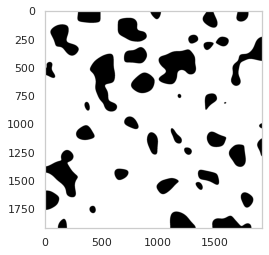

In [7]:
gt_img = generators.blobs(img_shape, porosity = 0.8, blobiness = 1.0)
plt.imshow(gt_img, cmap = 'gray')
np.sum(gt_img)/np.size(gt_img)

In [8]:
noise_std = 0.3
tsteps = 20
t_start = 3
img_series = np.zeros((tsteps,) + img_shape)
for ii in range(tsteps):
    
    if ii > t_start:
        gt_img = add_pores(gt_img, 256, void_size = 1.2, void_frac = 0.1)
    
    
    img_series[ii] = gt_img + np.random.normal(0, noise_std, img_shape)


In [ ]:
fig, ax = plt.subplots(4, int(np.ceil(tsteps//4)), figsize = (16,20))
sns.set_style("whitegrid", {'axes.grid' : False})
for ii in range(tsteps):
    ax.flat[ii].axis('off')
    ax.flat[ii].imshow(img_series[ii], cmap = 'gray')    
    ax.flat[ii].set_title("tstep %i"%ii)

fig.tight_layout()

## Simulate an acquisition  

In [ ]:
ndims = 3
max_patches = (4,4)
overlap = 20

In [ ]:
fe = FeatureExtraction2D(model_filename = model_filename, \
                         max_patches = max_patches, \
                         overlap = overlap)
# example
idx = 10
features = fe.extract_measurement(img_series[idx], \
                                  pore_analysis)
print(features)

In [ ]:
t_start = time.time()
map_f = fe.vis_feature(img_series[idx], pore_analysis)
t_end = time.time()
print("took %.2f seconds"%(t_end-t_start))

In [ ]:
fig, ax = plt.subplots(1,3)
labels = ["fraction", "number", "size"]
for ii in range(3):
    ax[ii].imshow(img_series[idx], cmap = 'gray')
    ax[ii].imshow(map_f[ii], cmap = 'copper', alpha = 0.2)
    ax[ii].set_title(labels[ii])
    ax[ii].axis('off')

In [ ]:
time_series = [fe.extract_measurement(img, pore_analysis) for img in img_series]
time_series = np.asarray(time_series)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.plot(np.arange(tsteps), time_series[:,0], label = "fraction")
ax.plot(np.arange(tsteps), time_series[:,1], label = "number")
ax.plot(np.arange(tsteps), time_series[:,2], label = "size")
ax.legend(fontsize = 12)
ax.set_xlabel("time step", fontsize = 12)
ax.set_ylabel("feature", fontsize = 12)

In [ ]:
pore_path = '/data02/MyArchive/quick_plots/pore_anim2'
os.makedirs(pore_path)
sns.set_style("whitegrid", {'axes.grid' : False})
for ii in range(tsteps):
    fig, ax = plt.subplots(1,2, figsize = (16,8))
    ax[0].axis('off')
    
    map_f = fe.vis_feature(img_series[ii], pore_analysis)
    ax[0].imshow(img_series[ii], cmap = 'gray')
    ax[0].imshow(map_f[1], cmap = 'copper', alpha = 0.2)
    ax[0].set_title("tstep %i"%ii)
    
    
    ax[1].plot(np.arange(tsteps), time_series[:,0], label = "pore fraction")
    ax[1].plot(np.arange(tsteps), time_series[:,1], label = "number of pores")
    ax[1].plot(np.arange(tsteps), time_series[:,2], label = "pore size")
    ax[1].legend(fontsize = 12)
    ax[1].scatter(ii, time_series[ii,0])
    ax[1].scatter(ii, time_series[ii,1])
    ax[1].scatter(ii, time_series[ii,2])
    ax[1].set_xlabel("time step", fontsize = 12)
    ax[1].set_ylabel("feature", fontsize = 12)
    
    plt.savefig(os.path.join(pore_path, "plot_%ii"%ii))
fig.tight_layout()

## Scaling with n patches  

In [ ]:
def get_time(imgs, fe, measurement, **kwargs):

    time_series = np.zeros((imgs.shape[0], ndims))
    times = []
    for ii, img in enumerate(imgs):


        for jj in range(niters):

            t_start = time.time()
            time_series[ii, :] = fe.extract_measurement(img, measurement, **kwargs)
            t_end = time.time()
            times.append(t_end-t_start)
    avg_time = 1000.0*np.mean(times)
#     print("Average time: %.2f ms"%(avg_time)  
    return avg_time

In [ ]:
n_patch_list = [1, 2, 3, 4, 5, 6, 7, 8]
niters = 5 # number of times to repeat operation for average time estimate
img_shape = (1920,1920)

fe = FeatureExtraction2D(model_filename = model_filename, \
                         max_patches = max_patches, \
                         overlap = overlap)
times_patching = []
for n_patch in n_patch_list:
    
    fe.max_patches = (n_patch, n_patch)
    
    this_time = get_time(img_series, fe, pore_analysis)
    times_patching.append(this_time)
    print("Average time: %.2f ms"%this_time)           

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.plot(n_patch_list, times_patching, '--', color = 'black')
ax.set_xlabel("number of patches (per side)", fontsize = 12)
ax.set_ylabel("time (milliseconds)", fontsize = 12)

## Noise analysis  

In [ ]:
seg_img = gt_img.copy()
SNR_steps = 10
std_vals = np.linspace(0.1,1.0, 10)
SNR = 1/std_vals
img_series_noise = np.asarray([seg_img + np.random.normal(0, std, seg_img.shape) for std in std_vals])

In [ ]:
fe = FeatureExtraction2D(model_filename = model_filename, \
                         max_patches = (2,2), \
                         overlap = 20)

In [ ]:
from ct_segnet.measurements import segmentation_accuracy

In [ ]:
SNR_series = [fe.extract_measurement(img, segmentation_accuracy, true_img = seg_img) for img in img_series_noise]
SNR_series = np.asarray(SNR_series)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.plot(SNR, SNR_series[:,0], label = "Jaccard IoU")
ax.plot(SNR, SNR_series[:,1], label = "Dice Score")
ax.legend(fontsize = 12)
ax.set_xlabel("SNR", fontsize = 12)
ax.set_ylabel("segmentation accuracy", fontsize = 12)

In [ ]:
fig, ax = plt.subplots(2, int(np.ceil(SNR_steps//2)), figsize = (16,8))

for ii in range(SNR_steps):
    ax.flat[ii].axis('off')
    ax.flat[ii].imshow(img_series_noise[ii], cmap = 'gray')    
    ax.flat[ii].set_title("SNR %.2f"%SNR[ii])

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
viewer.edge_plot(img_series[-1], gt_img, ax = ax)
ax.axis('off')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
ax.imshow(img_series[-1], cmap = 'gray')
ax.axis('off')

In [ ]:
time.ctime()

The end!